In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import xmlrpc.client as xml

In [2]:
plecs = xml.Server('http://localhost:1080/RPC2').plecs

#plecs.load(r"D:\Work\4. BOSCH\EMY-050\Simulation\Plecs\T-Type\CCM.plecs")

### TCM MODEL

In [2]:
work_dir = r'D:\Work\4. BOSCH\EMY-050\Simulation\Plecs\T-Type'
os.chdir(work_dir)
file_type = '.plecs'
model_name = 'TCM'

#### Getting Model parameters

In [4]:
plecs.set(model_name,'TimeSpan','0.5')

0

#### Initial Parameters

In [5]:
Vdc = 800
Vac = 230
fsw = 200e3
L = 50e-6
Cf = 10e-6
Cdc = 1280e-6
P = 3600

M = 2*Vac*(2)**0.5/Vdc
Imax = 3*P/Vdc*(3.0/2.0)**0.5
Rdc = Vdc**2/(Imax*Vac)
i = 0
Kp = L*fsw/3
Ki = 1e-4*fsw/3

init = ''
params = {'P' : P,'Cdc' : Cdc,'Vdc' : Vdc,'Vac' : Vac,
      'fsw' : fsw,'L' : L,'Cf' : Cf,'ESR' : 1e-4, 'M' : M,
      'I_max' : Imax,'Rdc' : Rdc,'Run' : i,'Kp' : Kp, 'Ki' : Ki,'w' : 5, 
      'TCM' : 0,'B_TCM' : 1, 'S_TCM' : 2, 'T3L_TCM' : 3}

plecs.set(model_name,'InitializationCommands',"")
for key,val in params.items():
    init += f'{key} = {val};\n'
    
plecs.set(model_name,'InitializationCommands',init)

0

<Axes: xlabel='fsw'>

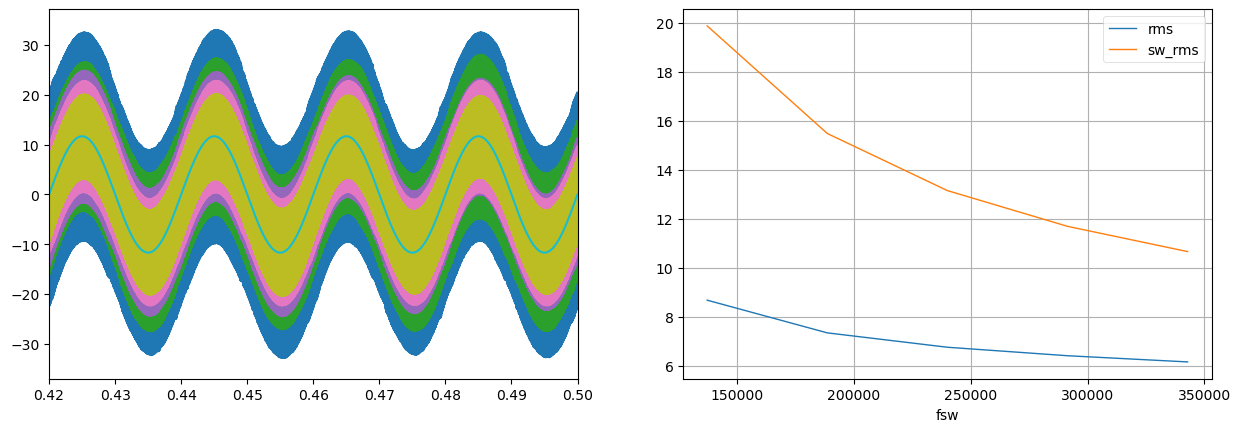

In [6]:
# Select modulation method
modulation = 'S_TCM'
# Change Simulation mode 
sim_mode = 1

# Number of simulation runs
Nmax = 5
L = 25e-6

frequency = np.linspace(200e3,500e3,Nmax)
P = 3600
plecs.set(model_name+f'/x{sim_mode}/Modulation','Value',modulation)
match sim_mode:
    case 1:
        Power = np.linspace(100,3600,Nmax)
        plecs.set(model_name+'/Manual Switch','SwitchState','on')
        plecs.set(model_name+'/x1','CommentStatus','Active')
        plecs.set(model_name+'/x2','CommentStatus','CommentedOut')
    case 2:
        Power = np.linspace(3600,7200,Nmax)
        plecs.set(model_name+'/Manual Switch','SwitchState','off')
        plecs.set(model_name+'/x1','CommentStatus','CommentedOut')
        plecs.set(model_name+'/x2','CommentStatus','Active')

df = pd.DataFrame()
df['fsw'] = frequency
init = ''

plecs.scope(model_name+f'/x{sim_mode}/Power-Voltages','ClearTraces')
plecs.scope(model_name+f'/x{sim_mode}/Averaging','ClearTraces')

fig,p=plt.subplots(1,2)
fig.set_figwidth(15)

for i,fsw in enumerate(frequency):

    M = 2*Vac*(2)**0.5/Vdc
    Imax = 3*P/Vdc*(3.0/2.0)**0.5
    Rdc = Vdc**2/(Imax*Vac)
   
    params = {'P' : P,'Cdc' : Cdc,'Vdc' : Vdc,'Vac' : Vac,
      'fsw' : fsw,'L' : L,'Cf' : Cf,'ESR' : 1e-4, 'M' : M,
      'I_max' : Imax,'Rdc' : Rdc,'Run' : i,'Kp' : Kp, 'Ki' : Ki,'w' : 5, 
      'TCM' : 0,'B_TCM' : 1, 'S_TCM' : 2, 'T3L_TCM' : 3}
    init = ''
    for key,val in params.items():
        init += f'{key} = {val};\n'
    plecs.set(model_name,'InitializationCommands',init)

    results = plecs.simulate(model_name)
    sim_time = results['Time']
    waves = results['Values']
    plecs.scope(model_name+f'/x{sim_mode}/Power-Voltages','HoldTrace',f'f = {fsw/1e3:.0f} kHz')
    plecs.scope(model_name+f'/x{sim_mode}/Averaging','HoldTrace',f'P = {fsw/1e3:.0f} kHz')
    
    df.loc[i,'rms'] = waves[0][-1]
    df.loc[i,'sw_rms']  = waves[1][-1]
    df.loc[i,'fsw']  = waves[2][-1]
    
    p[0].plot(sim_time,waves[3])
    p[0].plot(sim_time,waves[4])
    p[0].set_xlim(0.42,0.5)

plt.style.use('bmh')
df.plot(ax=p[1],x='fsw',y=['rms','sw_rms'])

In [102]:
df.to_csv('S_TCM_f_change.csv',index=False)

## Efficiency Calculation

In [111]:
df = pd.read_csv("S_TCM_f_change.csv")
df['frequency'] = frequency/1e3
df.head()

,fsw,rms,sw_rms,frequency
0,141799.791474,8.934069,20.639404,200.0
1,194976.467134,7.571032,16.125091,275.0
2,248153.265555,6.946281,13.686527,350.0
3,301330.084000,6.611495,12.208073,425.0
4,354506.937999,6.346147,11.137315,500.0


In [9]:
new_range = 100
#df = pd.read_csv("S_TCM_f_change.csv")
df['frequency'] = frequency/1e3

STCM = pd.DataFrame()
STCM['fsw'],STCM['rms']     = spline(df,'frequency','rms',new_range)
STCM['f_rms'],STCM['sw_rms']  = spline(df,'fsw','sw_rms',new_range)

# Estimate Conduction Losses
STCM["Cond_H"] = STCM["rms"]**2 * RdsOn_H
STCM["Cond_T"] = STCM["Cond_H"] * 4

# Estimate Switching Losses
STCM["Sw_H"] = [STCM.iloc[i]["fsw"] * PMTX04.interpolate(PMTX04.off_150[2],val) * 1e-6 for i,val in enumerate(STCM['sw_rms'].values)]
STCM["Sw_T"] = 4*STCM["Sw_H"]

STCM["Sw_loss"] = STCM["Cond_H"] + STCM["Sw_H"]
# Estimate the efficiency
STCM["Eff"] = 100*(P-STCM['Cond_T']-STCM["Sw_T"])/P

In [17]:
new_range = 100
frequency = np.linspace(200e3,500e3,10)
df = pd.read_csv("B_TCM_f_change.csv")
df['frequency'] = frequency/1e3

BTCM = pd.DataFrame()
BTCM['fsw'],BTCM['rms']     = spline(df,'frequency','rms',new_range)
BTCM['f_rms'],BTCM['sw_rms']  = spline(df,'fsw','sw_rms',new_range)

# Estimate Conduction Losses
BTCM["Cond_H"] = BTCM["rms"]**2 * RdsOn_H
BTCM["Cond_T"] = BTCM["Cond_H"] * 4

# Estimate Switching Losses
BTCM["Sw_H"] = [BTCM.iloc[i]["fsw"] * PMTX04.interpolate(PMTX04.off_150[2],val) * 1e-6 for i,val in enumerate(BTCM['sw_rms'].values)]
BTCM["Sw_T"] = 4*BTCM["Sw_H"]

BTCM["Sw_loss"] = BTCM["Cond_H"] + BTCM["Sw_H"]
# Estimate the efficiency
BTCM["Eff"] = 100*(P-BTCM['Cond_T']-BTCM["Sw_T"])/P

<Axes: title={'center': '3.6 kW Efficiency (%)'}, xlabel='fsw'>

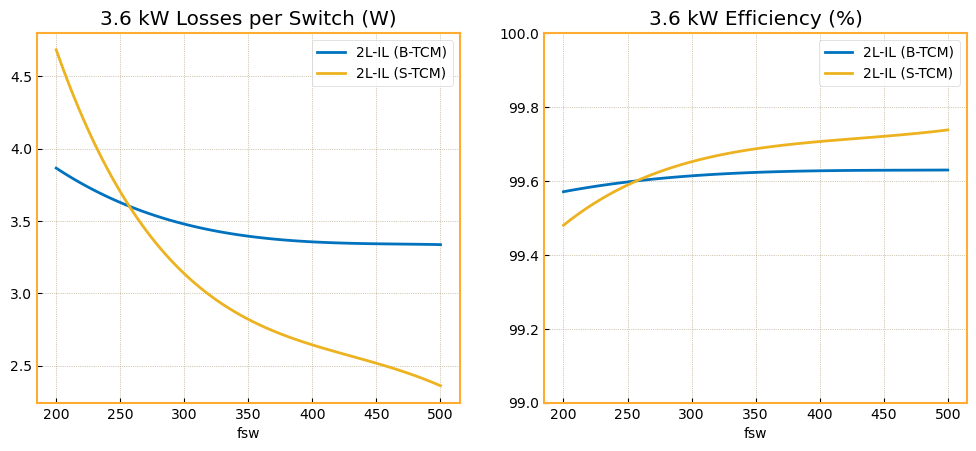

In [19]:

fig,p = plt.subplots(1,2)
fig.set_figwidth(12)
p[0].set_title('3.6 kW Losses per Switch (W)')
p[1].set_title('3.6 kW Efficiency (%)')

BTCM.plot(ax=p[0],x="fsw",y="Cond_H",label="2L-IL (B-TCM)",lw=2)
STCM.plot(ax=p[0],x="fsw",y="Cond_H",label="2L-IL (S-TCM)",lw=2)

BTCM.plot(ax=p[1],x="fsw",y="Eff",label="2L-IL (B-TCM)",ylim=(99,100),lw=2)
STCM.plot(ax=p[1],x="fsw",y="Eff",label="2L-IL (S-TCM)",ylim=(99,100),lw=2)

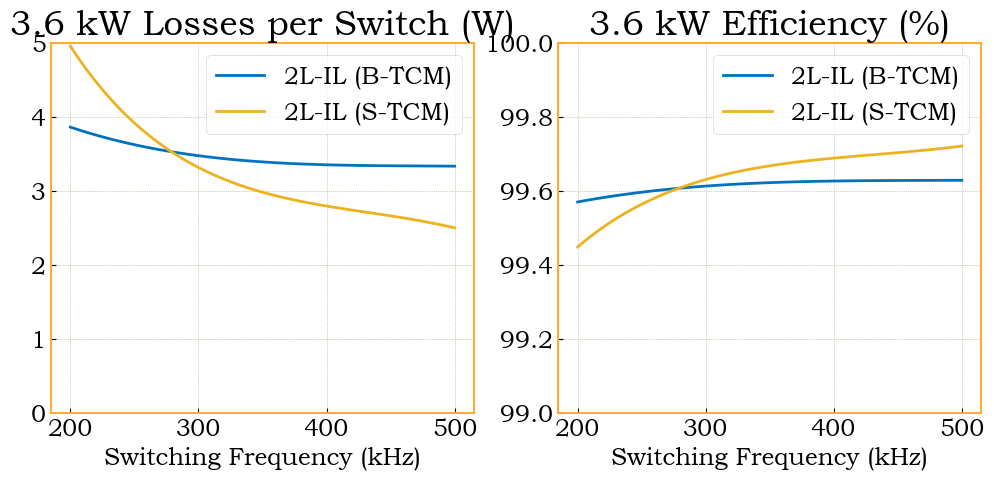

In [121]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.sans-serif'] = ['Bookman Old Style']  # Replace 'Arial' with your desired font
plt.rcParams['font.size'] = 17.5  # Example size

fig,p = plt.subplots(1,2)
fig.set_figwidth(12)
p[0].set_title('3.6 kW Losses per Switch (W)')
p[1].set_title('3.6 kW Efficiency (%)')

BTCM.plot(ax=p[0],x="fsw",y="Sw_loss",label="2L-IL (B-TCM)",ylim=(0,5),lw=2)
BTCM.plot(ax=p[1],x="fsw",y="Eff",label="2L-IL (B-TCM)",ylim=(99,100),lw=2)
STCM.plot(ax=p[0],x="fsw",y="Sw_loss",label="2L-IL (S-TCM)",ylim=(0,5),lw=2)
STCM.plot(ax=p[1],x="fsw",y="Eff",label="2L-IL (S-TCM)",ylim=(99,100),lw=2)

[ax.set_xlabel("Switching Frequency (kHz)") for ax in p]

fig.savefig("S-TCM_Efficiency.svg")

### 3LTCM Model

In [13]:
work_dir = r'D:\Work\4. BOSCH\EMY-050\Simulation\Plecs\T-Type'
os.chdir(work_dir)
file_type = '.plecs'
model_name = 'TTYPE_TCM'

In [14]:
Vdc = 800
Vac = 230
fsw = 200e3
L = 5/fsw
Cf = 100e-9
Cdc = 1280e-6
P = 3600

M = 2*Vac*(2)**0.5/Vdc
Imax = 3*P/Vdc*(3.0/2.0)**0.5
Rdc = Vdc**2/(Imax*Vac)
i = 0
Kp = L*fsw/3
Ki = 1e-4*fsw/3

init = ''
params = {'P' : P,'Cdc' : Cdc,'Vdc' : Vdc,'Vac' : Vac,
      'fsw' : fsw,'L' : L,'Cf' : Cf,'ESR' : 1e-4, 'M' : M,
      'I_max' : Imax,'Rdc' : Rdc,'Run' : i,'Kp' : Kp, 'Ki' : Ki,
      'TCM' : 0,'B_TCM' : 1, 'S_TCM' : 2, 'T3L_TCM' : 3}

plecs.set(model_name,'InitializationCommands',"")
for key,val in params.items():
    init += f'{key} = {val};\n'
    
plecs.set(model_name,'InitializationCommands',init)

0

In [ ]:
# Select modulation method
modulation = 'T3L_TCM'
# Change Simulation mode 
sim_mode = 1

# Number of simulation runs
Nmax = 3

frequency = np.linspace(200e3,500e3,Nmax)
P = 3600
plecs.set(model_name+f'/x{sim_mode}/Modulation','Value',modulation)
match sim_mode:
    case 1:
        Power = np.linspace(100,3600,Nmax)
        plecs.set(model_name+'/Manual Switch','SwitchState','on')
        plecs.set(model_name+'/x1','CommentStatus','Active')
        plecs.set(model_name+'/x2','CommentStatus','CommentedOut')
    case 2:
        Power = np.linspace(3600,7200,Nmax)
        plecs.set(model_name+'/Manual Switch','SwitchState','off')
        plecs.set(model_name+'/x1','CommentStatus','CommentedOut')
        plecs.set(model_name+'/x2','CommentStatus','Active')

df = pd.DataFrame()
df['fsw'] = frequency
init = ''

plecs.scope(model_name+f'/x{sim_mode}/Power-Voltages','ClearTraces')
plecs.scope(model_name+f'/x{sim_mode}/Averaging','ClearTraces')

fig,p=plt.subplots(1,2)
fig.set_figwidth(15)

for i,fsw in enumerate(frequency):

    M = 2*Vac*(2)**0.5/Vdc
    Imax = 3*P/Vdc*(3.0/2.0)**0.5
    Rdc = Vdc**2/(Imax*Vac)
    L = 5.0/fsw
    params = {'P' : P,'Cdc' : Cdc,'Vdc' : Vdc,'Vac' : Vac,
      'fsw' : fsw,'L' : L,'Cf' : Cf,'ESR' : 1e-4, 'M' : M,
      'I_max' : Imax,'Rdc' : Rdc,'Run' : i,'Kp' : Kp, 'Ki' : Ki,
      'TCM' : 0,'B_TCM' : 1, 'S_TCM' : 2, 'T3L_TCM' : 3}
    init = ''
    for key,val in params.items():
        init += f'{key} = {val};\n'
    plecs.set(model_name,'InitializationCommands',init)

    results = plecs.simulate(model_name)
    sim_time = results['Time']
    waves = results['Values']
    plecs.scope(model_name+f'/x{sim_mode}/Power-Voltages','HoldTrace',f'f = {fsw/1e3:.0f} kHz')
    plecs.scope(model_name+f'/x{sim_mode}/Averaging','HoldTrace',f'P = {fsw/1e3:.0f} kHz')
    
    df.loc[i,'rms_h'] = waves[0][-1]
    df.loc[i,'rms_n'] = waves[1][-1]
    df.loc[i,'sw_rms_h']  = waves[2][-1]
    df.loc[i,'sw_rms_n']  = waves[3][-1]
    df.loc[i,'fsw_rms']  = waves[4][-1]
    df.loc[i,'fsw_max'] = waves[5].max()
    
    p[0].plot(sim_time,waves[5])
    p[0].set_xlim(0.46,0.5)

plt.style.use('bmh')
df.plot(ax=p[2],x='fsw',y=['rms_h','rms_n'])
df.plot(ax=p[2],x='fsw',y=['sw_rms_h','sw_rms_n'])

### MOSFET CLASS

In [3]:
from scipy.interpolate import interp1d, UnivariateSpline
def spline(df,x,y,new_range):
    spline_function = UnivariateSpline(df[x], df[y])
    big_range = np.linspace(df.loc[0,x],df.loc[df.shape[0]-1,x],new_range)
    y_spline = spline_function(big_range)
    return big_range, y_spline

class MOSFET:
    def __init__(self):
        # Initialize the on_25 and off_25 members as lists of lists
        self.current = [0,1,3,5,10,20,30,40,50,60]
        self.on_25 = [[], [], []]
        self.off_25 = [[], [], []]
        self.on_150 = [[], [], []]
        self.off_150 = [[], [], []]
    def set_RdsOn(self,RdsOn):
        self.RdsOn = RdsOn
        
    def plot_curve(self, y_values):
        plt.plot(self.current,y_values)
    def interpolate(self, y_values, x):
        """
        Interpolate the y value corresponding to x given a list of x_values and y_values.
        
        :param x_values: List of x coordinates (must be sorted).
        :param y_values: List of y coordinates corresponding to x_values.
        :param x: The x value to interpolate.
        :return: The interpolated y value.
        """
        x_values = self.current
        if not x_values or not y_values or len(x_values) != len(y_values):
            raise ValueError("x_values and y_values must be non-empty and of the same length.")

        # Perform linear interpolation
        for i in range(1, len(x_values)):
            if x_values[i-1] <= x <= x_values[i]:
                # Linear interpolation formula: y = y0 + (x - x0) * (y1 - y0) / (x1 - x0)
                x0, y0 = x_values[i-1], y_values[i-1]
                x1, y1 = x_values[i], y_values[i]
                y = y0 + (x - x0) * (y1 - y0) / (x1 - x0)
                return y

        # If x is outside the range of x_values, raise an error or handle as needed
        raise ValueError("x value is outside the interpolation range.")
        
RdsOn_H = 62.2e-3
RdsOn_N = 38.7e-3

PMTX04 = MOSFET()
PMTW04 = MOSFET()
PMTW04.set_RdsOn = RdsOn_N
PMTX04.set_RdsOn = RdsOn_H

PMTX04.on_25[0] = [23.33,24.88,27.61,30.31,37.17,52.10,68.71,86.96,106.90,128.48] # 300 V
PMTX04.on_25[1] = [69.64,71.11,82.58,90.75,112.06,157.45,207.43,262.16,320.99,384.85] # 600 V
PMTX04.on_25[2] = [135.77,144.35,163.44,178.04,221.15,314.21,415.29,524.81,642.09,768.92] # 900 V

PMTX04.on_150[0] = [22.90,24.41,27.10,29.84,36.72,52.16,70.08,90.38,112.93,137.72] # 300 V
PMTX04.on_150[1] = [68.85,73.24,81.39,89.40,110.08,155.08,204.93,259.42,319.35,383.84] # 600 V
PMTX04.on_150[2] = [134.62,143.08,159.55,175.82,217.44,307.50,405.77,512.74,628.56,752.06] #900 V

PMTX04.off_25[0] = [8.12e-5,4.05e-4,5.94e-3,1.88e-2,9.98e-2,8.30e-1,4.51e0,1.30e1,2.54e1,4.08e1] # 300 V
PMTX04.off_25[1] = [8.11e-5,4.05e-4,5.94e-3,1.88e-2,9.9e-2,8.48e-1,1.07e1,3.41e1,6.32e1,9.63e1] # 600 V
PMTX04.off_25[2] = [8.11e-5,4.05e-4,5.94e-3,1.88e-2,9.99e-2,8.58e-1,2.39e1,7.27e1,1.3e2,1.92e2] # 900 V

PMTX04.off_150[0] =[0.000146,0.000778,0.011149,0.03475,0.169,1.211,5.792,15.47,28.97,45.51] # 300 V
PMTX04.off_150[1] =[0.000146,0.000778,0.011145,0.034737,0.1688,1.245,14.758,40.75,71.94,106.97] # 600 V
PMTX04.off_150[2] =[0.000146,0.000777,0.0111,0.03473,0.1687,1.274,32.57,84.81,144.47,209.26] # 900 V

PMTW04.on_25[0] = [23.33,24.88,27.61,30.31,37.17,52.10,68.71,86.96,106.90,128.48] # 200 V
PMTW04.on_25[1] = [69.64,71.11,82.58,90.75,112.06,157.45,207.43,262.16,320.99,384.85] # 400 V
PMTW04.on_25[2] = [135.77,144.35,163.44,178.04,221.15,314.21,415.29,524.81,642.09,768.92] # 600 V

PMTW04.on_150[0] = [] # 200 V
PMTW04.on_150[1] = [43.58,46.77,52.81,58.79,74.16,107.35,144.21,184.76,229.02,277.19] # 400 V
PMTW04.on_150[2] = [] # 600 V

PMTW04.off_25[0] = [8.12e-5,4.05e-4,5.94e-3,1.88e-2,9.98e-2,8.30e-1,4.51e0,1.30e1,2.54e1,4.08e1] # 200 V
PMTW04.off_25[1] = [8.11e-5,4.05e-4,5.94e-3,1.88e-2,9.9e-2,8.48e-1,1.07e1,3.41e1,6.32e1,9.63e1] # 400 V
PMTW04.off_25[2] = [8.11e-5,4.05e-4,5.94e-3,1.88e-2,9.99e-2,8.58e-1,2.39e1,7.27e1,1.3e2,1.92e2] # 600 V

PMTW04.off_150[0] =[] # 200 V
PMTW04.off_150[1] =[0.000434,0.000195,0.00585,0.024251,0.1475,2.4,18.06,39.97,65.57,94.33] # 400 V
PMTW04.off_150[2] =[] # 600 V